In [1]:
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [2]:
df = pd.read_excel('/Users/qkrtm/Desktop/KAU/4-1/종설/gitJongsul/RNN/dataset/종서박_glucose.xlsx','sheet1')
#df = ex1.parse('sheet1')
df.to_csv('csvfile.csv',encoding='utf-8')
#df = pd.read_csv(csv_path)
#나중에 리브레뷰의 혈당데이터를 읽어 예측해보려한다,

In [3]:
df.tail()
#교수님의 혈당데이터는 총 2129개
#이제 이 데이터를 통해 저번에 했던 3일치 정도의 혈당을 예측해보자
# 3일  = 하루 세끼 3개 * 3 은 총 9개예측하기

,Time,(mg/dL),Age,Sex
2125,2020-04-24 21:36:00,86,61,1
2126,2020-04-24 21:56:00,73,61,1
2127,2020-04-24 21:56:00,92,61,1
2128,2020-04-24 23:41:00,94,61,1
2129,2020-04-25 04:32:00,102,61,1


In [4]:
#history_size는 과거 정보 창의 크기
# target_size는 미래 예측 레이블값

In [5]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

In [6]:
TRAIN_SPLIT = 1000
tf.random.set_seed(13)

In [7]:
# train1 : 일 변량 시계열 예측 = 단일 온도만 사용해서 모델 학습 후에
#해당 값을 예측
#데이터 셋에서 온도 만 추출하기
uni_data = df['(mg/dL)']
uni_data.index = df['Time']
uni_data.tail()

Time
2020-04-24 21:36:00     86
2020-04-24 21:56:00     73
2020-04-24 21:56:00     92
2020-04-24 23:41:00     94
2020-04-25 04:32:00    102
Name: (mg/dL), dtype: int64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000025BF3025F48>],
      dtype=object)

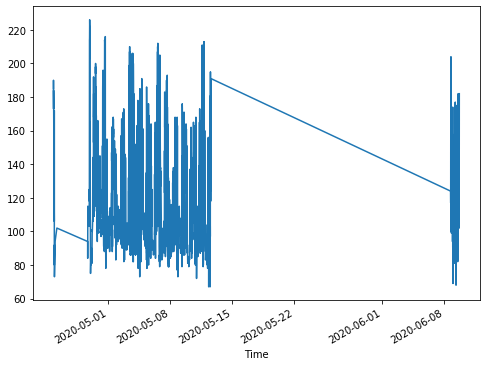

In [8]:
uni_data.plot(subplots=True)
#교수님의 4월 28일 부터 6월 9일까지의 혈당 데이터이다. 중간에 텀이 사용하지 않았던 시기

In [9]:
uni_data = uni_data.values

In [10]:
#uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
#uni_train_std = uni_data[:TRAIN_SPLIT].std()

In [11]:
#uni_data = (uni_data-uni_train_mean)/uni_train_std

In [12]:
#마지막 20개의 혈당기록을 데이터로 가지고 다음 혈당수치 예측하기
univariate_past_history = 500
univariate_future_target = 9

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target-1)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

In [13]:
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target glucose to predict')
print (y_train_uni[0])

Single window of past history
[[115]
 [114]
 [108]
 [104]
 [107]
 [112]
 [109]
 [108]
 [111]
 [113]
 [114]
 [108]
 [103]
 [104]
 [107]
 [114]
 [125]
 [174]
 [214]
 [224]
 [226]
 [222]
 [203]
 [187]
 [165]
 [143]
 [123]
 [ 98]
 [ 79]
 [ 75]
 [ 79]
 [ 81]
 [ 80]
 [ 83]
 [ 86]
 [ 85]
 [ 86]
 [ 86]
 [ 86]
 [ 88]
 [ 89]
 [ 90]
 [ 87]
 [ 82]
 [ 81]
 [ 87]
 [ 97]
 [101]
 [100]
 [101]
 [104]
 [106]
 [107]
 [107]
 [106]
 [110]
 [110]
 [107]
 [109]
 [119]
 [128]
 [135]
 [153]
 [182]
 [173]
 [161]
 [154]
 [140]
 [124]
 [109]
 [121]
 [128]
 [130]
 [124]
 [120]
 [116]
 [115]
 [118]
 [123]
 [124]
 [132]
 [159]
 [194]
 [198]
 [196]
 [185]
 [176]
 [169]
 [163]
 [148]
 [137]
 [128]
 [120]
 [118]
 [112]
 [121]
 [130]
 [122]
 [111]
 [110]
 [111]
 [101]
 [ 94]
 [ 95]
 [100]
 [107]
 [143]
 [166]
 [147]
 [120]
 [129]
 [151]
 [151]
 [132]
 [122]
 [117]
 [120]
 [125]
 [137]
 [137]
 [117]
 [102]
 [105]
 [111]
 [110]
 [106]
 [102]
 [102]
 [122]
 [142]
 [145]
 [134]
 [127]
 [119]
 [110]
 [102]
 [ 99]
 [100]
 [ 9

In [14]:
#데이터 생성되었으므로 예측값 확인
def create_time_steps(length):
  return list(range(-length, 0))


In [15]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

<module 'matplotlib.pyplot' from 'C:\\Users\\qkrtm\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

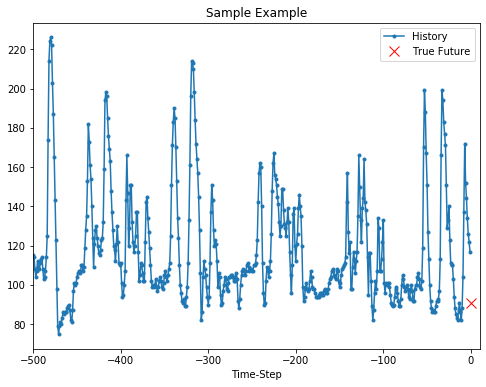

In [16]:
#올바른 예측 정답 값은 빨간 X
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

In [17]:
#베이스라인 = 입력지점 주어지면, 모든 기록의 다음 예측은 
#최근 100개의 관측치 평균으로 예측할 것(학습)

In [18]:
def baseline(history):
  return np.mean(history)

<module 'matplotlib.pyplot' from 'C:\\Users\\qkrtm\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

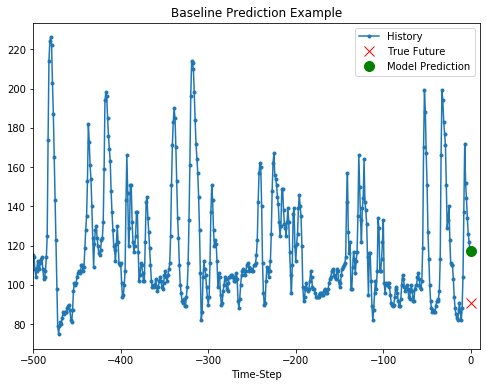

In [19]:
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,
           'Baseline Prediction Example')

In [20]:
#모델의 예측값이 정답 Y라벨을 생각보다 가깝게 잡아냄 혈당값만 가지고 예측한 상황

In [21]:
#이제 RNN사용
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [22]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

In [23]:
#옵티마이저는 아담, 손실함수는 mean abs를 사용

In [24]:
#모델 출력 확인을 위해 샘플 예측
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

(256, 1)


In [34]:
#모델 훈련 시키기 simple lstm 모델
EVALUATION_INTERVAL = 100
EPOCHS = 10

#simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                   #   steps_per_epoch=EVALUATION_INTERVAL,
                    #  validation_data=val_univariate, validation_steps=50)
uni_history = simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

Train for 100 steps, validate for 50 steps
Epoch 1/10
100/100 [==============================] - 29s 292ms/step - loss: 95.8902 - val_loss: 114.9497
Epoch 2/10
100/100 [==============================] - 30s 299ms/step - loss: 95.1697 - val_loss: 114.2409
Epoch 3/10
100/100 [==============================] - 31s 312ms/step - loss: 94.4620 - val_loss: 113.5332
Epoch 4/10
100/100 [==============================] - 30s 297ms/step - loss: 93.7508 - val_loss: 112.8264
Epoch 5/10
100/100 [==============================] - 32s 317ms/step - loss: 93.0520 - val_loss: 112.1204
Epoch 6/10
100/100 [==============================] - 30s 297ms/step - loss: 92.3475 - val_loss: 111.4150
Epoch 7/10
100/100 [==============================] - 44s 441ms/step - loss: 91.6510 - val_loss: 110.7102
Epoch 8/10
100/100 [==============================] - 49s 486ms/step - loss: 90.9466 - val_loss: 110.0059
Epoch 9/10
100/100 [==============================] - 48s 479ms/step - loss: 90.2360 - val_loss: 109.3021
Epo

In [35]:
#훈련 loss 는 0.0185, val loss 는 너무 작아짐
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

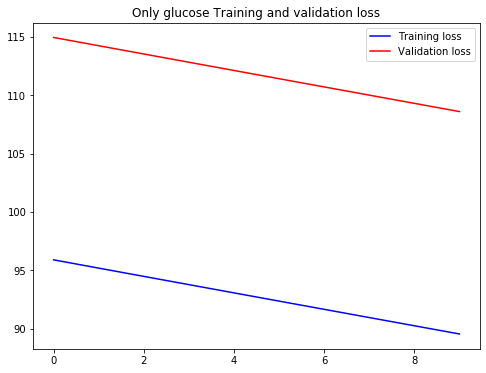

In [36]:
plot_train_history(uni_history,
                   'Only glucose Training and validation loss')

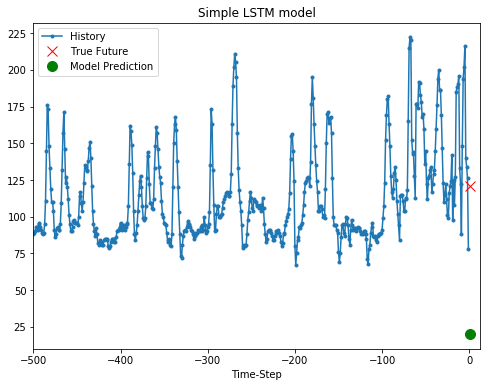

In [47]:
# 이 simple lstm 학습모델을 가지고 예측 시도
for x, y in val_univariate.take(1):
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]],1, 'Simple LSTM model')
  plot.show()

In [90]:

#다변량 시계열 예측
#나중에는 음식종류, 식사식전, 식후 칼로리로 나누자
#현재는 혈당만
features_considered = ['(mg/dL)']

In [91]:
features = df[features_considered]
features.index = df['Time']
features.head()

,(mg/dL)
Time,
2020-04-28 16:31:00,115
2020-04-28 16:46:00,114
2020-04-28 17:01:00,108
2020-04-28 17:16:00,104
2020-04-28 17:32:00,107


array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000025B8CA24788>],
      dtype=object)

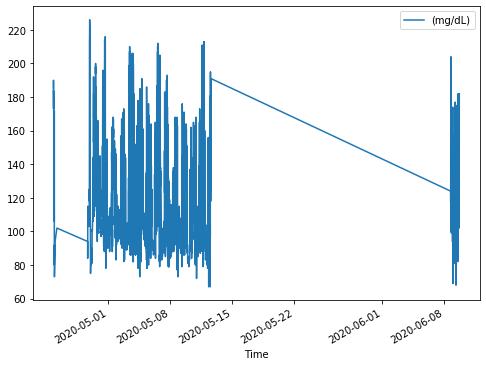

In [92]:
features.plot(subplots=True)

In [93]:
dataset = features.values
#data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
#data_std = dataset[:TRAIN_SPLIT].std(axis=0)

#dataset = (dataset-data_mean)/data_std

In [94]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [190]:
#720개(5일 * 6개(시간당)* 24시간(1일))
#예측 레이블 (12*6 즉 미래 12시간의 온도 예측)
past_history = 720
future_target = 15
STEP = 6

x_train_single, y_train_single = multivariate_data(dataset, dataset[:], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

In [191]:
print ('Single window of past history : {}'.format(x_train_single[0].shape))

Single window of past history : (120, 1)


In [192]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [193]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32,
                                           input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

In [194]:
#옵티마이저는 rmsprop으로 변경
for x, y in val_data_single.take(1):
  print(single_step_model.predict(x).shape)

(256, 1)


In [196]:
single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=30)

Train for 100 steps, validate for 30 steps
Epoch 1/10
100/100 [==============================] - 11s 106ms/step - loss: 94.6647 - val_loss: 111.3194
Epoch 2/10
100/100 [==============================] - 12s 120ms/step - loss: 92.0570 - val_loss: 109.0194
Epoch 3/10
100/100 [==============================] - 15s 148ms/step - loss: 89.5132 - val_loss: 106.7194
Epoch 4/10
100/100 [==============================] - 17s 167ms/step - loss: 87.6196 - val_loss: 104.4193
Epoch 5/10
100/100 [==============================] - 18s 180ms/step - loss: 84.8504 - val_loss: 102.1193
Epoch 6/10
100/100 [==============================] - 17s 173ms/step - loss: 83.2090 - val_loss: 99.8191
Epoch 7/10
100/100 [==============================] - 17s 170ms/step - loss: 80.1122 - val_loss: 97.5191
Epoch 8/10
100/100 [==============================] - 14s 143ms/step - loss: 77.3938 - val_loss: 95.2189
Epoch 9/10
100/100 [==============================] - 13s 131ms/step - loss: 75.6500 - val_loss: 92.9188
Epoch 1

In [197]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

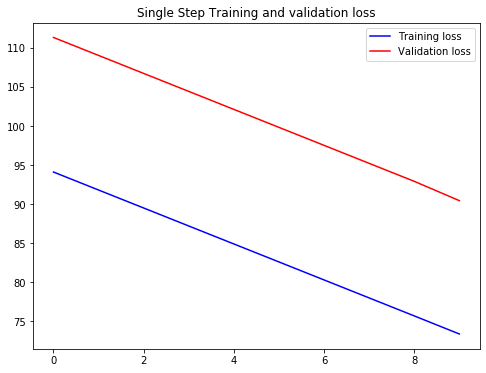

In [198]:
plot_train_history(single_step_history,
                   'Single Step Training and validation loss')

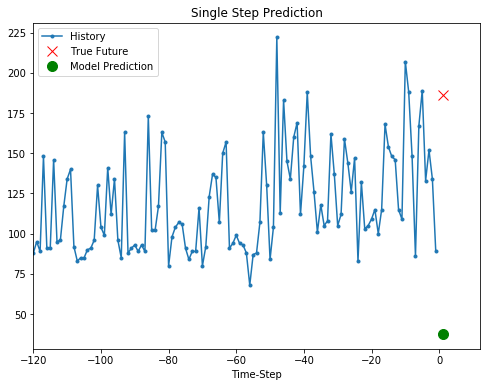

In [200]:
for x, y in val_data_single.take(1):
  plot = show_plot([x[0][:].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 1,
                   'Single Step Prediction')
  plot.show()

In [173]:
#과거 데이터를 가지고 미래 값을 예측
#15개  = 5일치예측 데이터 생성
future_target = 15
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

In [ ]:
print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\n Target glucose to predict : {}'.format(y_train_multi[0].shape))

In [175]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [178]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

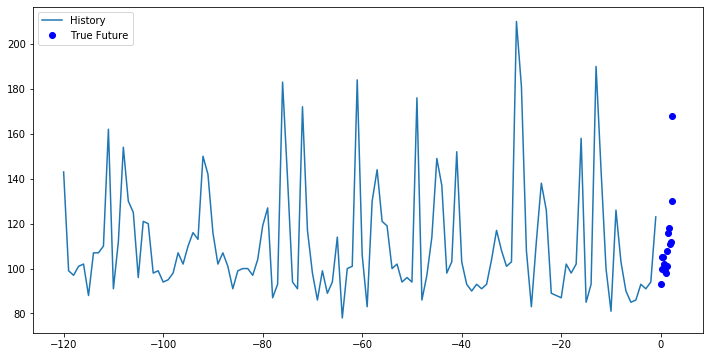

In [181]:
for x, y in train_data_multi.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))
#정답인 Y레이블을 파란 점으로 표현

In [185]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(15))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

In [186]:
#좀더 DEEP한 2개 LAYER 사용, 72개 예측값 출력
for x, y in val_data_multi.take(1):
  print (multi_step_model.predict(x).shape)
#우선 SHAPE을 출력

(256, 15)


In [187]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=30)
#학습을 시켜본다.

Train for 100 steps, validate for 30 steps
Epoch 1/10
100/100 [==============================] - 19s 195ms/step - loss: 106.3146 - val_loss: 123.3231
Epoch 2/10
100/100 [==============================] - 17s 171ms/step - loss: 102.6667 - val_loss: 118.7960
Epoch 3/10
100/100 [==============================] - 17s 171ms/step - loss: 86.0189 - val_loss: 72.2893
Epoch 4/10
100/100 [==============================] - 18s 181ms/step - loss: 55.7956 - val_loss: 66.7548
Epoch 5/10
100/100 [==============================] - 21s 213ms/step - loss: 48.9320 - val_loss: 55.2173
Epoch 6/10
100/100 [==============================] - 31s 314ms/step - loss: 83.9150 - val_loss: 88.3074
Epoch 7/10
100/100 [==============================] - 30s 305ms/step - loss: 39.5492 - val_loss: 56.7460
Epoch 8/10
100/100 [==============================] - 24s 242ms/step - loss: 95.4696 - val_loss: 58.5956
Epoch 9/10
100/100 [==============================] - 22s 217ms/step - loss: 43.9977 - val_loss: 53.0112
Epoch 10

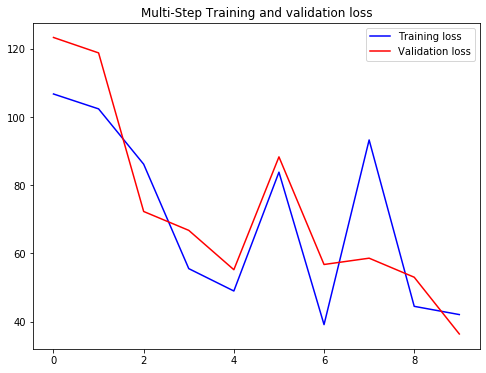

In [188]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

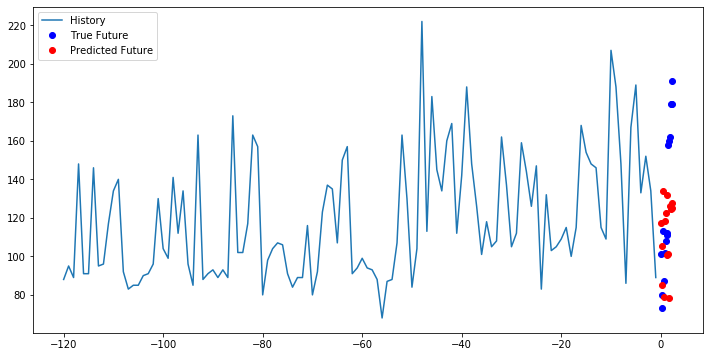

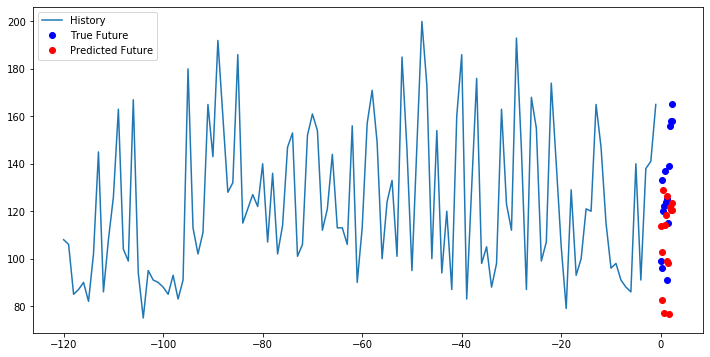

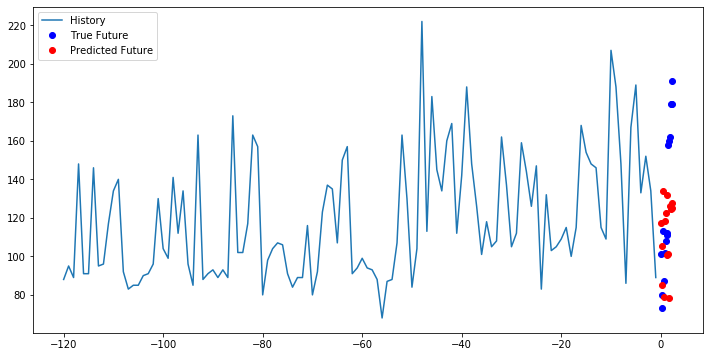

In [203]:
#학습된 네트워크가 미래예측을 잘 배웠는지 확인
#빨간 점이 예측값, 파란점이 실제 Y라벨
for x, y in val_data_multi.take(3):
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])